In [576]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума

In [577]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

### Реализуйте высокочастотную фильтрацию на основе ядра Гаусса

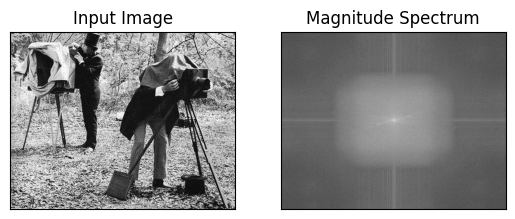

In [578]:
img = cv.imread('photograps.jpg', cv.IMREAD_GRAYSCALE)
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
 
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
 
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Функция высокочастотного гауссовского фильтра

In [579]:
def gaussian_highpass_filter(shape, sigma):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u, v, indexing='ij')

    d = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    # invert gaussian lowpass filter
    h = 1 - np.exp(-(d**2) / (2 * (sigma**2)))
    return h

Применяем ВЧ-фильтр Гаусса с разным параметром дисперсии 


Compare results with diff sigma: [10, 30, 50]


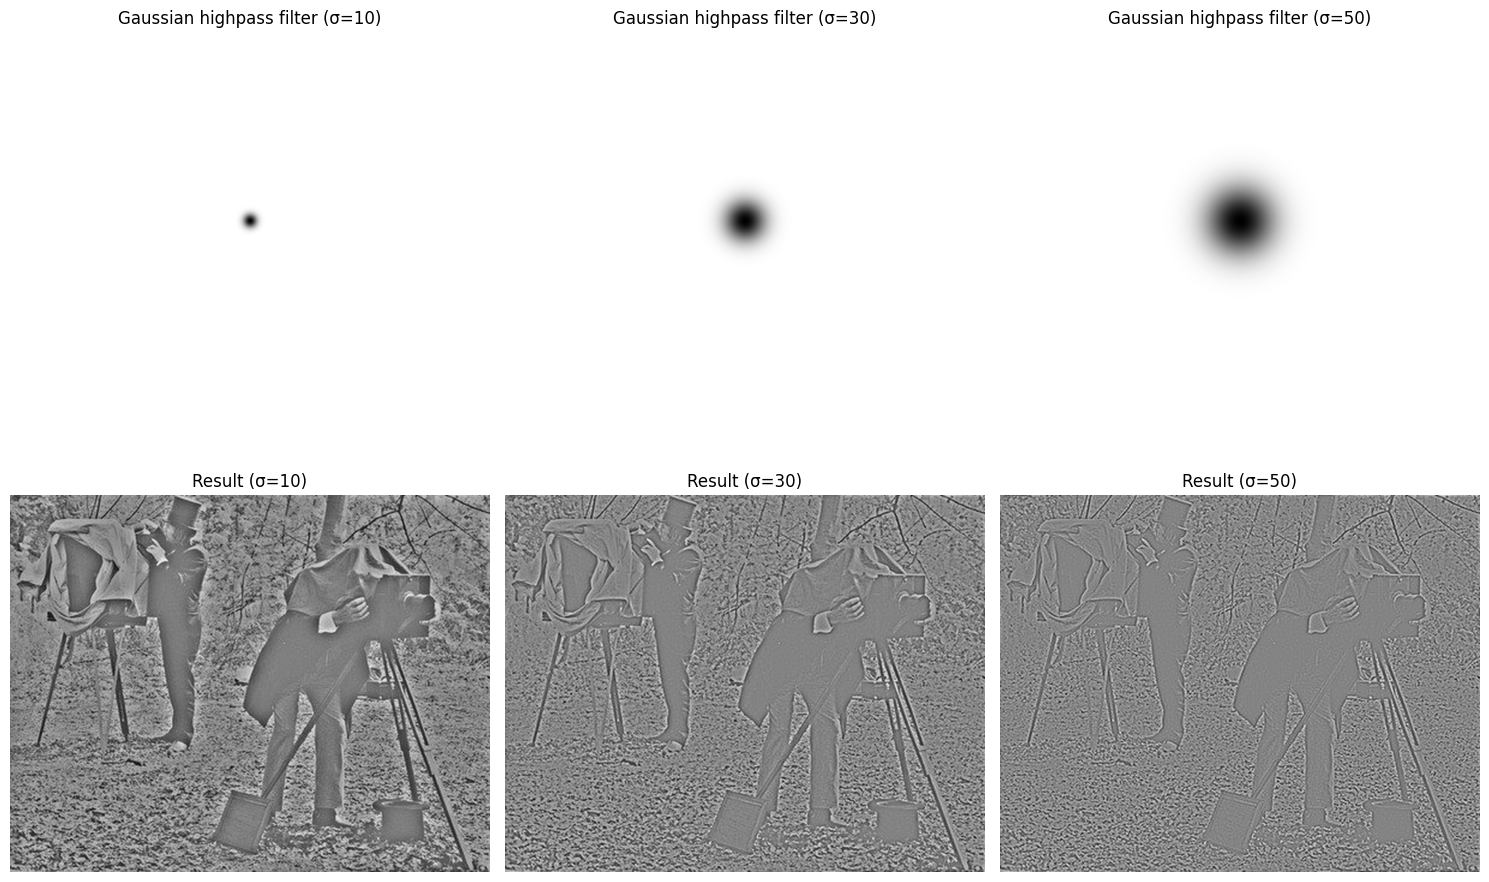

In [580]:
sigmas = [10, 30, 50]
results = []
fft_image = np.fft.fft2(img)
for i, sigma in enumerate(sigmas):
    hp_filter = gaussian_highpass_filter(img.shape, sigma)
    fft_shifted = np.fft.fftshift(fft_image)
    filtered_fft = fft_shifted * hp_filter
    filtered_image = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))
    filtered_image = cv.normalize(filtered_image, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
    results.append((sigma, hp_filter, filtered_image)) 

print(f"\nCompare results with diff sigma: {sigmas}")
plt.figure(figsize=(15, 10))

for i, (sigma, hp_filter, filtered_image) in enumerate(results):
    plt.subplot(2, 3, i+1)
    plt.imshow(hp_filter, cmap='gray')
    plt.title(f'Gaussian highpass filter (σ={sigma})')
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'Result (σ={sigma})')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Реализуйте удаление периодического шума

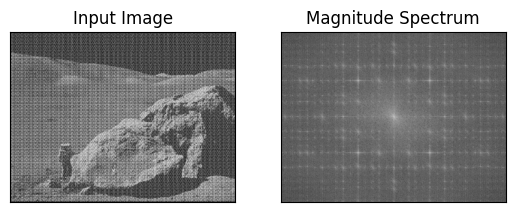

In [581]:
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
 
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
 
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Функции удаления периодического шума

Notch filter

In [582]:
def create_notch_filter(shape, noise_points, line_thickness=2):
    rows, cols = shape
    mask = np.ones((rows, cols), np.float32)
    
    for point in noise_points:
        y, x = point
        cv.line(mask, (x, 0), (x, rows), 0, line_thickness)
        cv.line(mask, (0, y), (cols, y), 0, line_thickness)
    
    return mask


Band reject

In [583]:
def create_band_reject(shape, noise_points, circle_thickness=1):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)
    
    for point in noise_points:
        y, x = point
        distance = np.sqrt((x - ccol)**2 + (y - crow)**2)
        cv.circle(mask, (ccol, crow), int(distance), 0, circle_thickness)
    
    return mask

Функция поиска точек шума

In [584]:
def detect_noise_points(spectrum, threshold_ratio=0.62, min_distance=80):
    rows, cols = spectrum.shape
    crow, ccol = rows // 2, cols // 2
    
    spectrum_norm = cv.normalize(spectrum, None, 0, 255, cv.NORM_MINMAX)
    _, binary = cv.threshold(spectrum_norm.astype(np.uint8), 
                             np.max(spectrum_norm) * threshold_ratio, 
                             255, cv.THRESH_BINARY)
    
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    noise_points = []
    for contour in contours:
        M = cv.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            distance = np.sqrt((cx - ccol)**2 + (cy - crow)**2)
            if distance > min_distance:
                noise_points.append((cy, cx))
    
    return noise_points

Применение фильтров

Detected noise points: 18


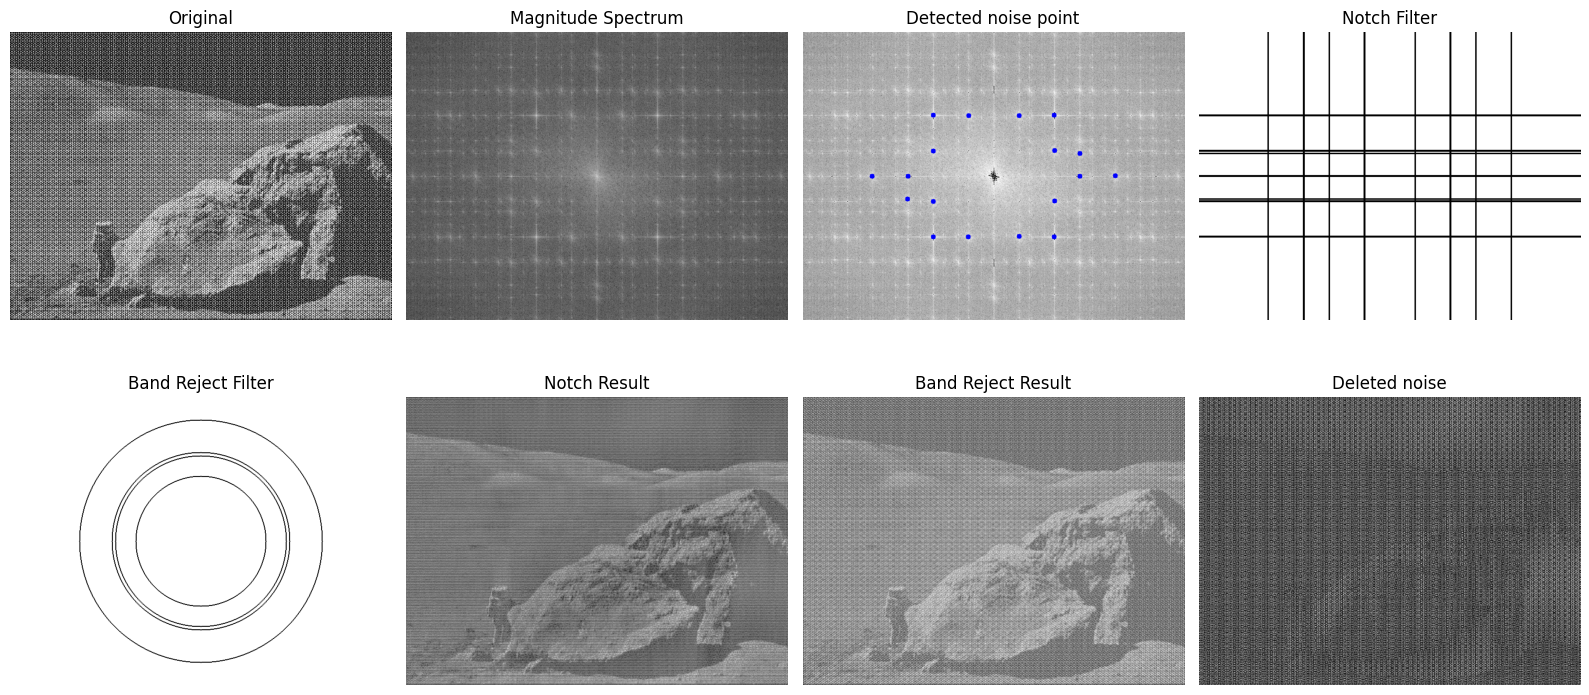

In [585]:
dft = np.fft.fft2(img)
dft_shifted = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(1 + np.abs(dft_shifted))

noise_points = detect_noise_points(magnitude_spectrum)
print(f"Detected noise points: {len(noise_points)}")

notch_filter = create_notch_filter(img.shape, noise_points)
band_reject_filter = create_band_reject(img.shape, noise_points)

dft_notch = dft_shifted * notch_filter
notch_result = np.real(np.fft.ifft2(np.fft.ifftshift(dft_notch)))
notch_result = cv.normalize(notch_result, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

dft_band = dft_shifted * band_reject_filter
band_result = np.real(np.fft.ifft2(np.fft.ifftshift(dft_band)))
band_result = cv.normalize(band_result, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0,0].imshow(img, cmap='gray')
axes[0,0].set_title('Original')
axes[0,0].axis('off')

axes[0,1].imshow(magnitude_spectrum, cmap='gray')
axes[0,1].set_title('Magnitude Spectrum')
axes[0,1].axis('off')

spectrum_with_points = cv.cvtColor(magnitude_spectrum.astype(np.uint8), cv.COLOR_GRAY2BGR)
for point in noise_points:
    y, x = point
    cv.circle(spectrum_with_points, (x, y), 5, (0, 0, 255), -1)

axes[0,2].imshow(spectrum_with_points)
axes[0,2].set_title('Detected noise point')
axes[0,2].axis('off')

axes[0,3].imshow(notch_filter, cmap='gray')
axes[0,3].set_title('Notch Filter')
axes[0,3].axis('off')

axes[1,0].imshow(band_reject_filter, cmap='gray')
axes[1,0].set_title('Band Reject Filter')
axes[1,0].axis('off')

axes[1,1].imshow(notch_result, cmap='gray')
axes[1,1].set_title('Notch Result')
axes[1,1].axis('off')

axes[1,2].imshow(band_result, cmap='gray')
axes[1,2].set_title('Band Reject Result')
axes[1,2].axis('off')

noise_component = cv.absdiff(img, notch_result)
axes[1,3].imshow(noise_component, cmap='gray')
axes[1,3].set_title('Deleted noise')
axes[1,3].axis('off')

plt.tight_layout()
plt.show()